In [1]:
import platform
print(platform.python_version())

3.8.8


# IMPORT LIBRARIES

In [2]:
#============== Import Libraries ==================================#
import os
import sys
import pyodbc
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pickle
from dateutil.parser import parse 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

# DATABASE CONNECTION TO MSSQL SERVER

In [3]:
#================= Create Database Connection ======================#
engine = pyodbc.connect("DRIVER={SQL Server};"
                      "Server=192.168.1.35;"
                      "UID=sa;"
                      "PWD=Abc12345;"
                      "Database=PBIDASHBYKDS;"
                      "Trusted_Connection=NO;")
cursor =engine.cursor()

pd.options.display.float_format = '{:,.2f}'.format

# CALL QUERY STORED PROCEDURE MSSQL SERVER

In [4]:
sql_query = """SET NOCOUNT ON; EXEC [dbo].[KSP_PREDICTIVE_ANALYTICS_DAILY];""".format(input)
df = pd.read_sql_query(sql_query , engine)

df.tail(120)

,ORDERDATE,FDAY,FMTH,FYEAR,DEMANDQTY,ITEM,DESCRIPTION,CATEGORY,QTYSHIP,CANCELQTY
205,2018-08-31,31,08,2018,493.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,490.00,3.00
206,2018-09-06,06,09,2018,12.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,12.00,0.00
207,2018-09-19,19,09,2018,21.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,21.00,0.00
208,2018-09-26,26,09,2018,6.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,6.00,0.00
209,2018-09-30,30,09,2018,652.33,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,652.33,0.00
...,...,...,...,...,...,...,...,...,...,...
320,2022-02-08,08,02,2022,5.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,5.00,0.00
321,2022-02-17,17,02,2022,4.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,4.00,0.00
322,2022-02-28,28,02,2022,432.42,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,461.42,29.00
323,2022-03-02,02,03,2022,1.00,F-SSS-103-000,SERI SONGKET EARLGREY TANGERINE 12X20'S ...,SSS,1.00,0.00


# PLOT TREND LINE FOR DEMAND QTY 

<AxesSubplot:title={'center':'BOH Seri Songket Earl Grey with Tangerine 12 x20sachets x2g  DEMAND TREND'}>

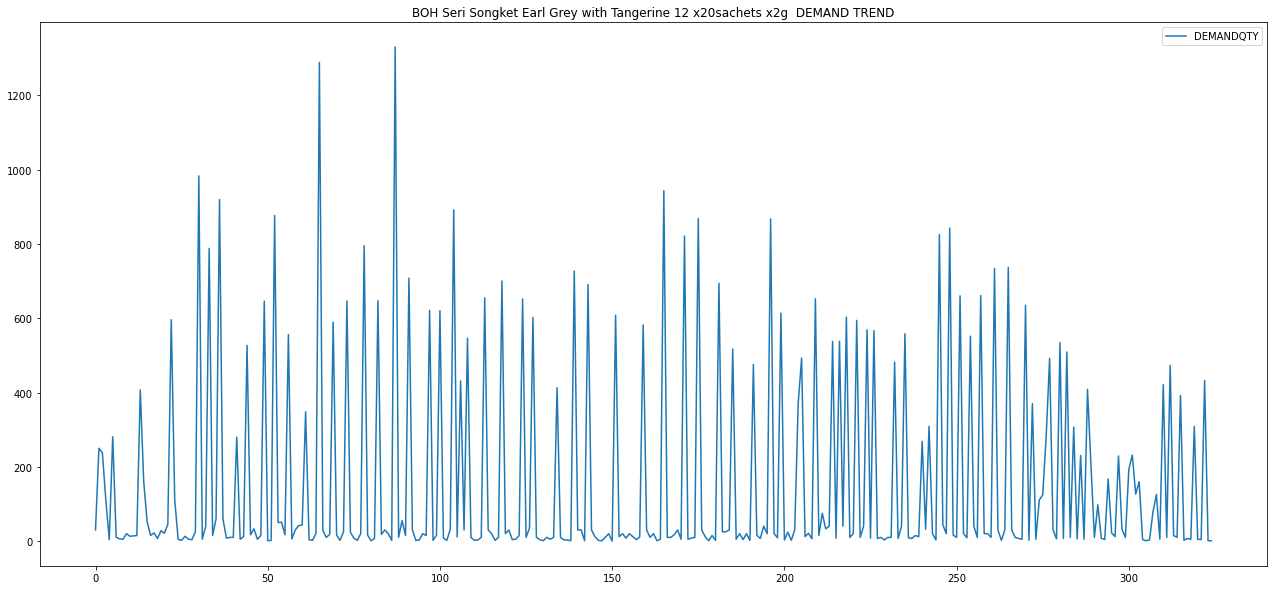

In [6]:
df=df.drop(['FDAY','FMTH','FYEAR','ITEM', 'DESCRIPTION','CATEGORY','QTYSHIP','CANCELQTY'], axis = 1)
df.plot(figsize=(22,10), title="BOH Seri Songket Earl Grey with Tangerine 12 x20sachets x2g  DEMAND TREND")

Check stationarity.
A time series is stationary if it satisfies the following three conditions.

1. Mean of the series over time is constant
2. Variance of the series over time is constant.
3. No seasonality.

Classic Time series modelling techniques like AR(Auto Regression), MA(Moving Average), ARMA (AR + MA) etc., won’t work if there is no stationarity in the time series.

We have to check for the stationarity of the series by

1. Visually inspecting the plot as above.
2. Advanced test methodologies like Dickey Fuller test as we do below.

# DATA PRE-PROCESSING

In [5]:
#====== DATA PRE-PROCESSING======================

#====== CHECK NULL VALUE

df.isnull().sum()

ORDERDATE      0
FDAY           0
FMTH           0
FYEAR          0
DEMANDQTY      0
ITEM           0
DESCRIPTION    0
CATEGORY       0
QTYSHIP        0
CANCELQTY      0
dtype: int64

In [7]:
df

,ORDERDATE,DEMANDQTY
0,2014-12-29,30.00
1,2015-01-31,249.92
2,2015-02-28,237.58
3,2015-03-11,110.00
4,2015-03-31,4.00
...,...,...
320,2022-02-08,5.00
321,2022-02-17,4.00
322,2022-02-28,432.42
323,2022-03-02,1.00


In [8]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [9]:
df = df.set_index('ORDERDATE').asfreq('M')

In [10]:
df.tail(24)

,DEMANDQTY
ORDERDATE,
2020-04-30,110.33
2020-05-31,124.67
2020-06-30,281.17
2020-07-31,492.08
2020-08-31,534.42
2020-09-30,509.17
2020-10-31,307.00
2020-11-30,230.75
2020-12-31,408.58


In [11]:
df.isnull().sum()

DEMANDQTY    1
dtype: int64

In [12]:
df=df.replace(np.NaN,df.mean())

In [13]:
df.isnull().sum()

DEMANDQTY    0
dtype: int64

In [14]:
result = seasonal_decompose(df, model='ad')

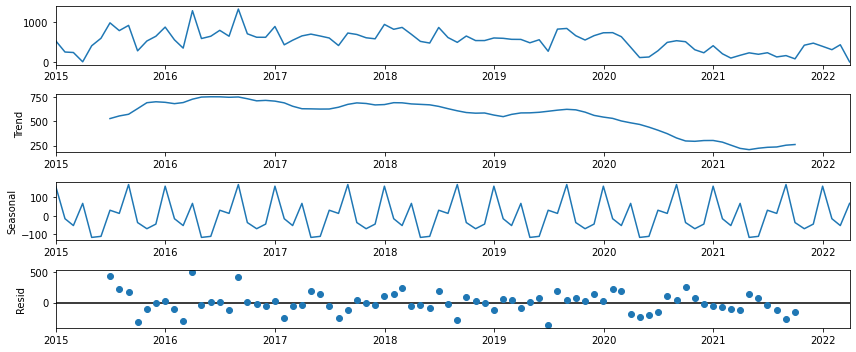

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
result.plot();

# DICKEY FULLER TEST

In [16]:
# DF test

from statsmodels.tsa.stattools import adfuller

def df_test(time_series):
    print('Results of Dickey Fuller Test:')
    dftest=adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-Value', 'Number of lag used', 'Number of Obeservation Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key]=value
        
    print(dfoutput)

In [17]:
df_test(df)

Results of Dickey Fuller Test:
Test Statistic                -3.01
p-Value                        0.03
Number of lag used             2.00
Number of Obeservation Used   85.00
Critical Value (1%)           -3.51
Critical Value (5%)           -2.90
Critical Value (10%)          -2.59
dtype: float64


The p-Value is significantly low =0.03, indicating the differenced time series is stationary.

According to DF test, the hypothesis is that given the time series is stationary. A low p-value =<0.05 support the hypothesis.

now break up the trend, seasonality, residual(noise) components separately and visualize them using seasonal_decompose() method provided by statsmodels api.



Firts order difefrencing

Have to make time series stationary by removing the trend. Use differencing technique (taking the difference between value at each time step and its value at the corresponding previous time step). First order dofferencing is substracting value at each time step(t) and value at time step(t-1)


In [18]:
print(list(df))

['DEMANDQTY']


<AxesSubplot:xlabel='ORDERDATE'>

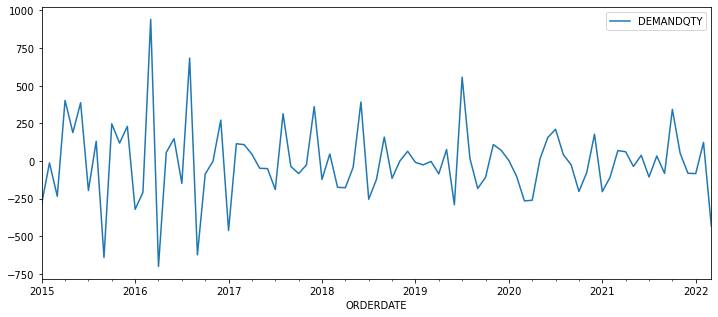

In [19]:
first_diff = df.diff()[1:]
first_diff.plot()

The first difference series show constant mean and variance centered around zero ( though the variance is not perfectly constant).

In [20]:
df_test(first_diff)

Results of Dickey Fuller Test:
Test Statistic                -7.19
p-Value                        0.00
Number of lag used             3.00
Number of Obeservation Used   83.00
Critical Value (1%)           -3.51
Critical Value (5%)           -2.90
Critical Value (10%)          -2.59
dtype: float64


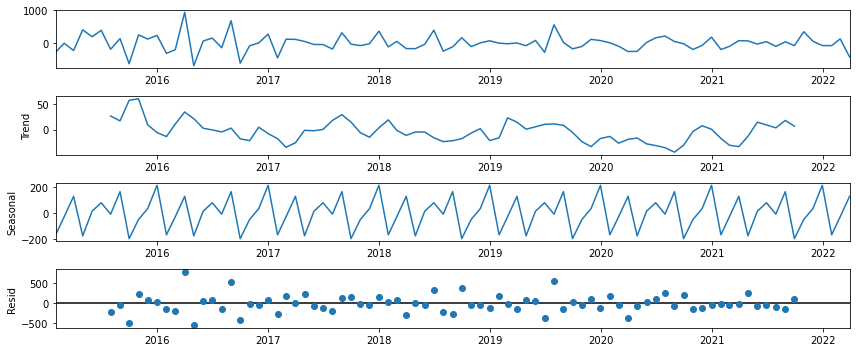

In [21]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(first_diff).plot()
plt.show()

We see the upward and downward trend and a clear seasonality (repeating pattern) in the original time series. The residuals look normally distributed around zero which is fine.

Since we see both seasonality and trend in the original time series,
we will use SARIMA algorithm which stands for Seasonal ARIMA ( Seasonal Auto Regressive Integrated Moving Average )

It has two sets of parameters- Non-seasonal (p,d,q) and Seasonal (P,D,Q,m).

We can break SARIMA in to

1. Seasonality

The algorithm takes in to consideration the seasonality of the time series via some parameters we feed it (P,D,Q,m).

2. AR- Auto Regressive

This forecasting method assumes that the value at any time step t can be calculated as a regression involving the values of the same series in one or more previous time steps (this is referred as Auto — i.e. previous values of it’s own ). The number of these time steps is referred as AR lags ( denoted by p parameter ).

3. I- Integrated

Differencing is done for removing the trend and to achieve stationarity. The order of differencing is given by parameter d. In our case, d=1 as we do first difference.

4. MA- Moving Average

This forecasting method assumes that the value at any time step t can be calculated as a regression involving the errors (in forecast) seen for previous time steps. The number of these time steps is referred as MA lags (denoted by q parameter ).

The parameters (P,D,Q) are seasonal counterparts of p,q and d.
‘m’ is the number of time steps in which there is a repetition of seasonality ( for example, 12 months if one time step is one month and seasonal pattern repeats in duration of one year ). P is the seasonal AR lag, Q is seasonal MA lag, D is seasonal difference order.

From the time series and seasonality plots that we saw earlier, we can observe m = 12 ( One year ).

ACF and PACF Analysis
For determining p and q, we need to plot PACF (Partial Auto Correlation Function ) and ACF ( Auto Correlation Function) respectively, which we will do next.

# AUTOCORRELATION ACF

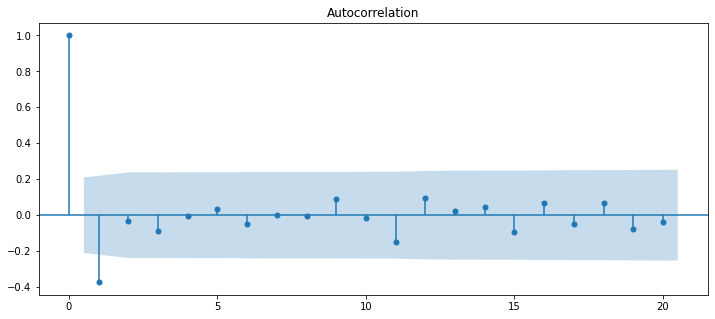

In [22]:
#ACF

from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(first_diff)

Each stick in the plot corresponds to lags starting from 0 ( which has the maximum correlation of 1 as it is the correlation of a time step’s value with itself ).

From ACF it appears lags 1 (t-1) and 2 (t-2) are significant for MA (q parameter).

# PARTIAL AUTOCORRELATION PACF

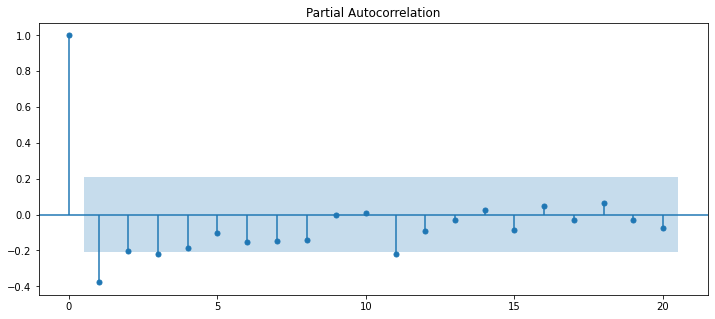

In [23]:
pacf_plot = plot_pacf(first_diff)

Each stick in the plot corresponds to lags starting from 0 ( which has the maximum correlation of 1 as it is correlation of a time step’s value with itself ).

The lag 1 and 11 indicates seasonal pattern.

Before we go further with advanced algorithm , let us build a base line model ( based on Holt Winters algorithm )

Baseline Model — Holt Winters Algorithm

The idea behind Holt’s Winters method is to apply exponential smoothing to the seasonal components in addition to level and trend.
We will first split the time series in to train and test data based on the dates.

In [24]:
from datetime import timedelta

train_end = datetime(2021,6,30)
test_end = datetime(2022,3,31)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [25]:
train_data.tail(5)

,DEMANDQTY
ORDERDATE,
2021-02-28,97.92
2021-03-31,167.50
2021-04-30,229.25
2021-05-31,193.25
2021-06-30,231.67


In [26]:
test_data.head(5)

,DEMANDQTY
ORDERDATE,
2021-07-31,126.33
2021-08-31,159.92
2021-09-30,78.00
2021-10-31,421.17
2021-11-30,473.17


# HOLT WINTERS TEST AND FORECAST 

In [27]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [41]:
holt_winter = ExponentialSmoothing(np.array(train_data['DEMANDQTY']))
hw_fit = holt_winter.fit()
hw_forecast = hw_fit.forecast(len(test_data))


C:\Users\FadhilahNurIsmail\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


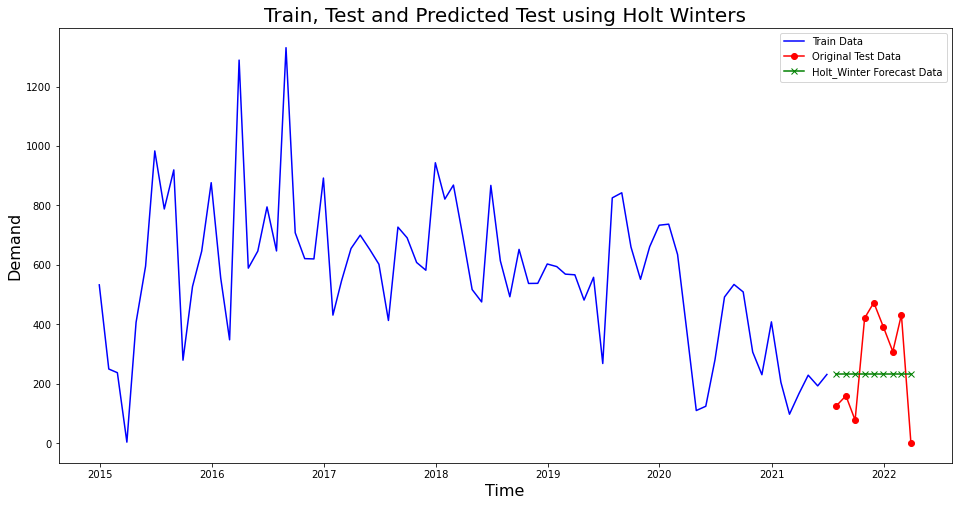

In [42]:
plt.figure(figsize=(16,8))

plt.plot(train_data.index, train_data['DEMANDQTY'], "b-", label='Train Data')
plt.plot(test_data.index, test_data['DEMANDQTY'], "ro-", label='Original Test Data')
plt.plot(test_data.index, hw_forecast, "gx-", label='Holt_Winter Forecast Data')
plt.ylabel('Demand', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc='best')
plt.title('Train, Test and Predicted Test using Holt Winters', fontsize=20)
plt.show()

AttributeError: 'ExponentialSmoothing' object has no attribute 'plot'

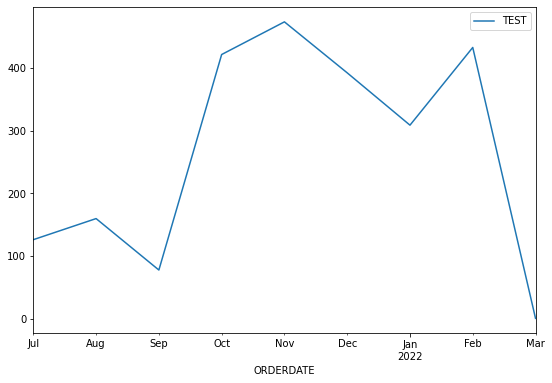

In [44]:
test_data['DEMANDQTY'].plot(legend=True,label='TEST',figsize=(9,6))
holt_winter.plot(legend=True,label='PREDICTION',xlim=['2021-6-30','2022-3-31']);